[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/polynomial_regression.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Polynomial Regression

This notebook shows an example of polynomial linear regression using Stochastic Gradient Descent. It is an example of how to detect and handle outliers and missing values in a dataset. Nonetheless, remember that no single *magic recipe* or fixed method exists for data science.


We use a modification of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing.csv`. The dataset contains the following columns:
- price (dependent variable or target): Price of the house (in USD).
- width: Width of the house (in square feet).
- length: Length of the house (in square feet).
- bedrooms: Number of bedrooms.
- bathrooms: Number of bathrooms.
- stories: Number of stories.
- mainroad: Whether the house is near a main road (yes or no).
- guestroom: Whether the house has a guest room (yes or no).
- basement: Whether the house has a basement (yes or no).
- hotwaterheating: Whether the house has hot water heating (yes or no).
- airconditioning: Whether the house has air conditioning (yes or no).
- parking: Number of parking spots.
- prefarea: Whether the house is in a preferred area (yes or no).
- furnishingstatus: Furnishing status of the house (furnished, semi-furnished, unfurnished).
- quality: An integer value representing the quality of the house.

In [1]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

repo='data-science-course'
module='regression'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We load the dataset from the file, split in train and test sets, and visualize the distribution of the variable values. Then, we handle outliers and missing values, and we transform the variable types to be able to use them in the model.

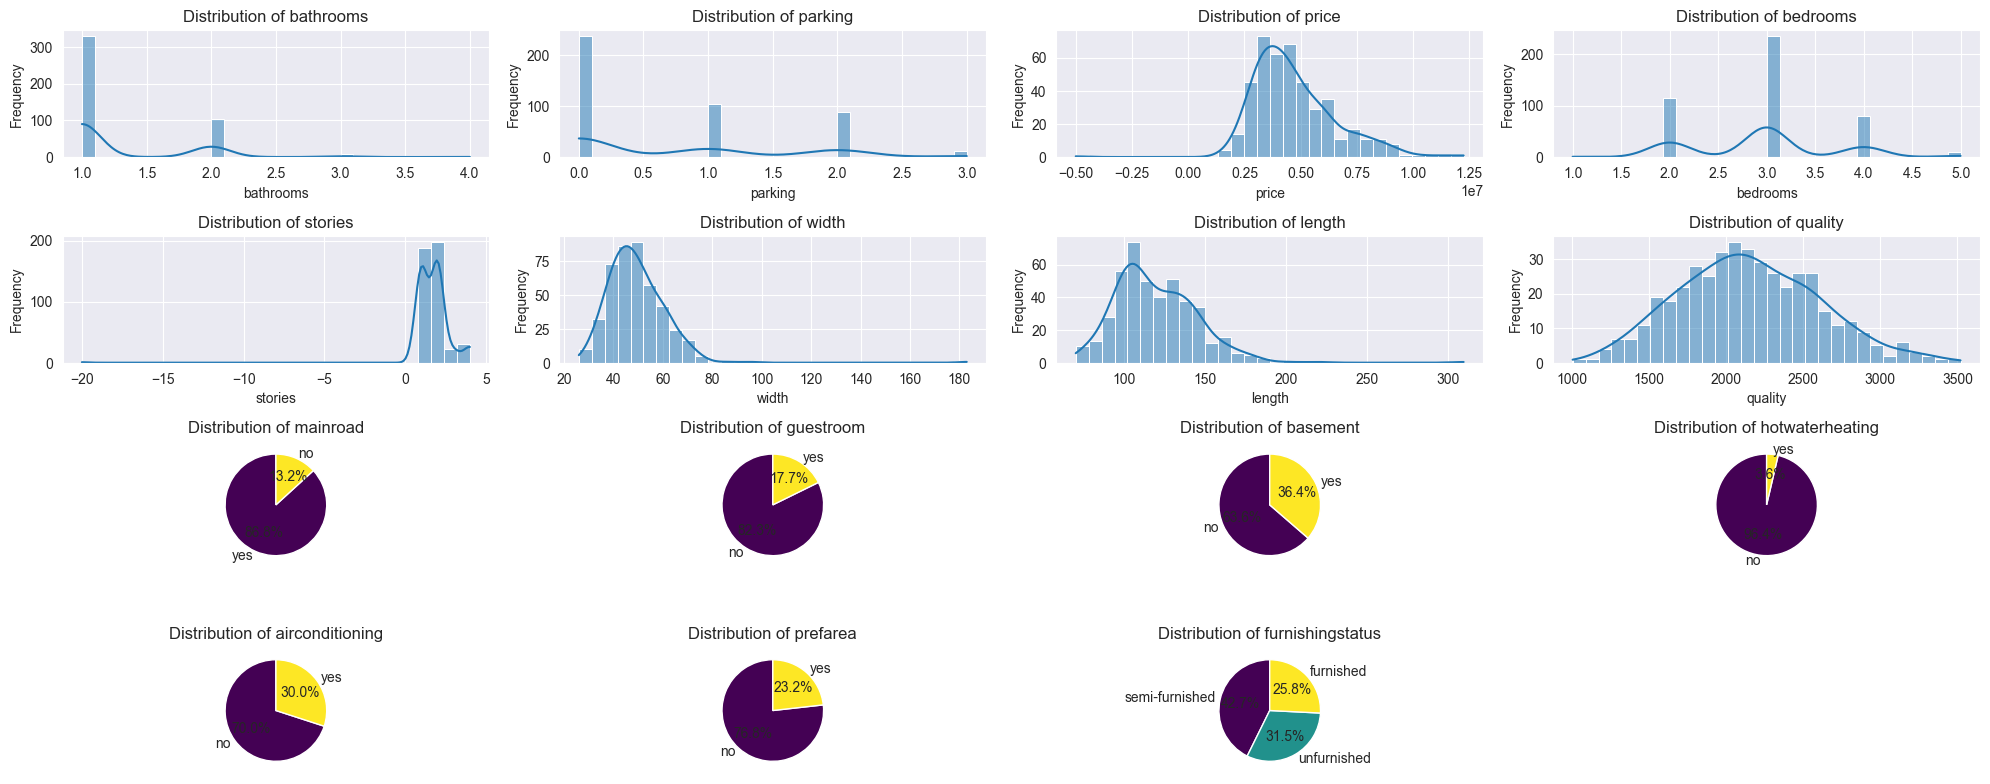

In [2]:
dataset_file_name = 'data/housing.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
nominal_independent_vars = ['furnishingstatus']
independent_vars = integer_independent_vars + binary_independent_vars + nominal_independent_vars
dependent_var = 'price'

# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
# Concatenate X_train and y_train in train_dataset to visualize all the variables, including the target
train_dataset = pd.concat([X_train, y_train], axis=1)
# Visualize the distribution of the dataset
utils.plot_feature_value_distribution(train_dataset)

We can also visually analyze the correlation between the non-nominal variables in the dataset using a pairplot. It creates a matrix of scatter plots for each pair of variables in the dataset, allowing us to see the relationships between them. In the diagonal, it shows the distribution of each variable using histograms. *Remember*: it only shows non-nominal variables.

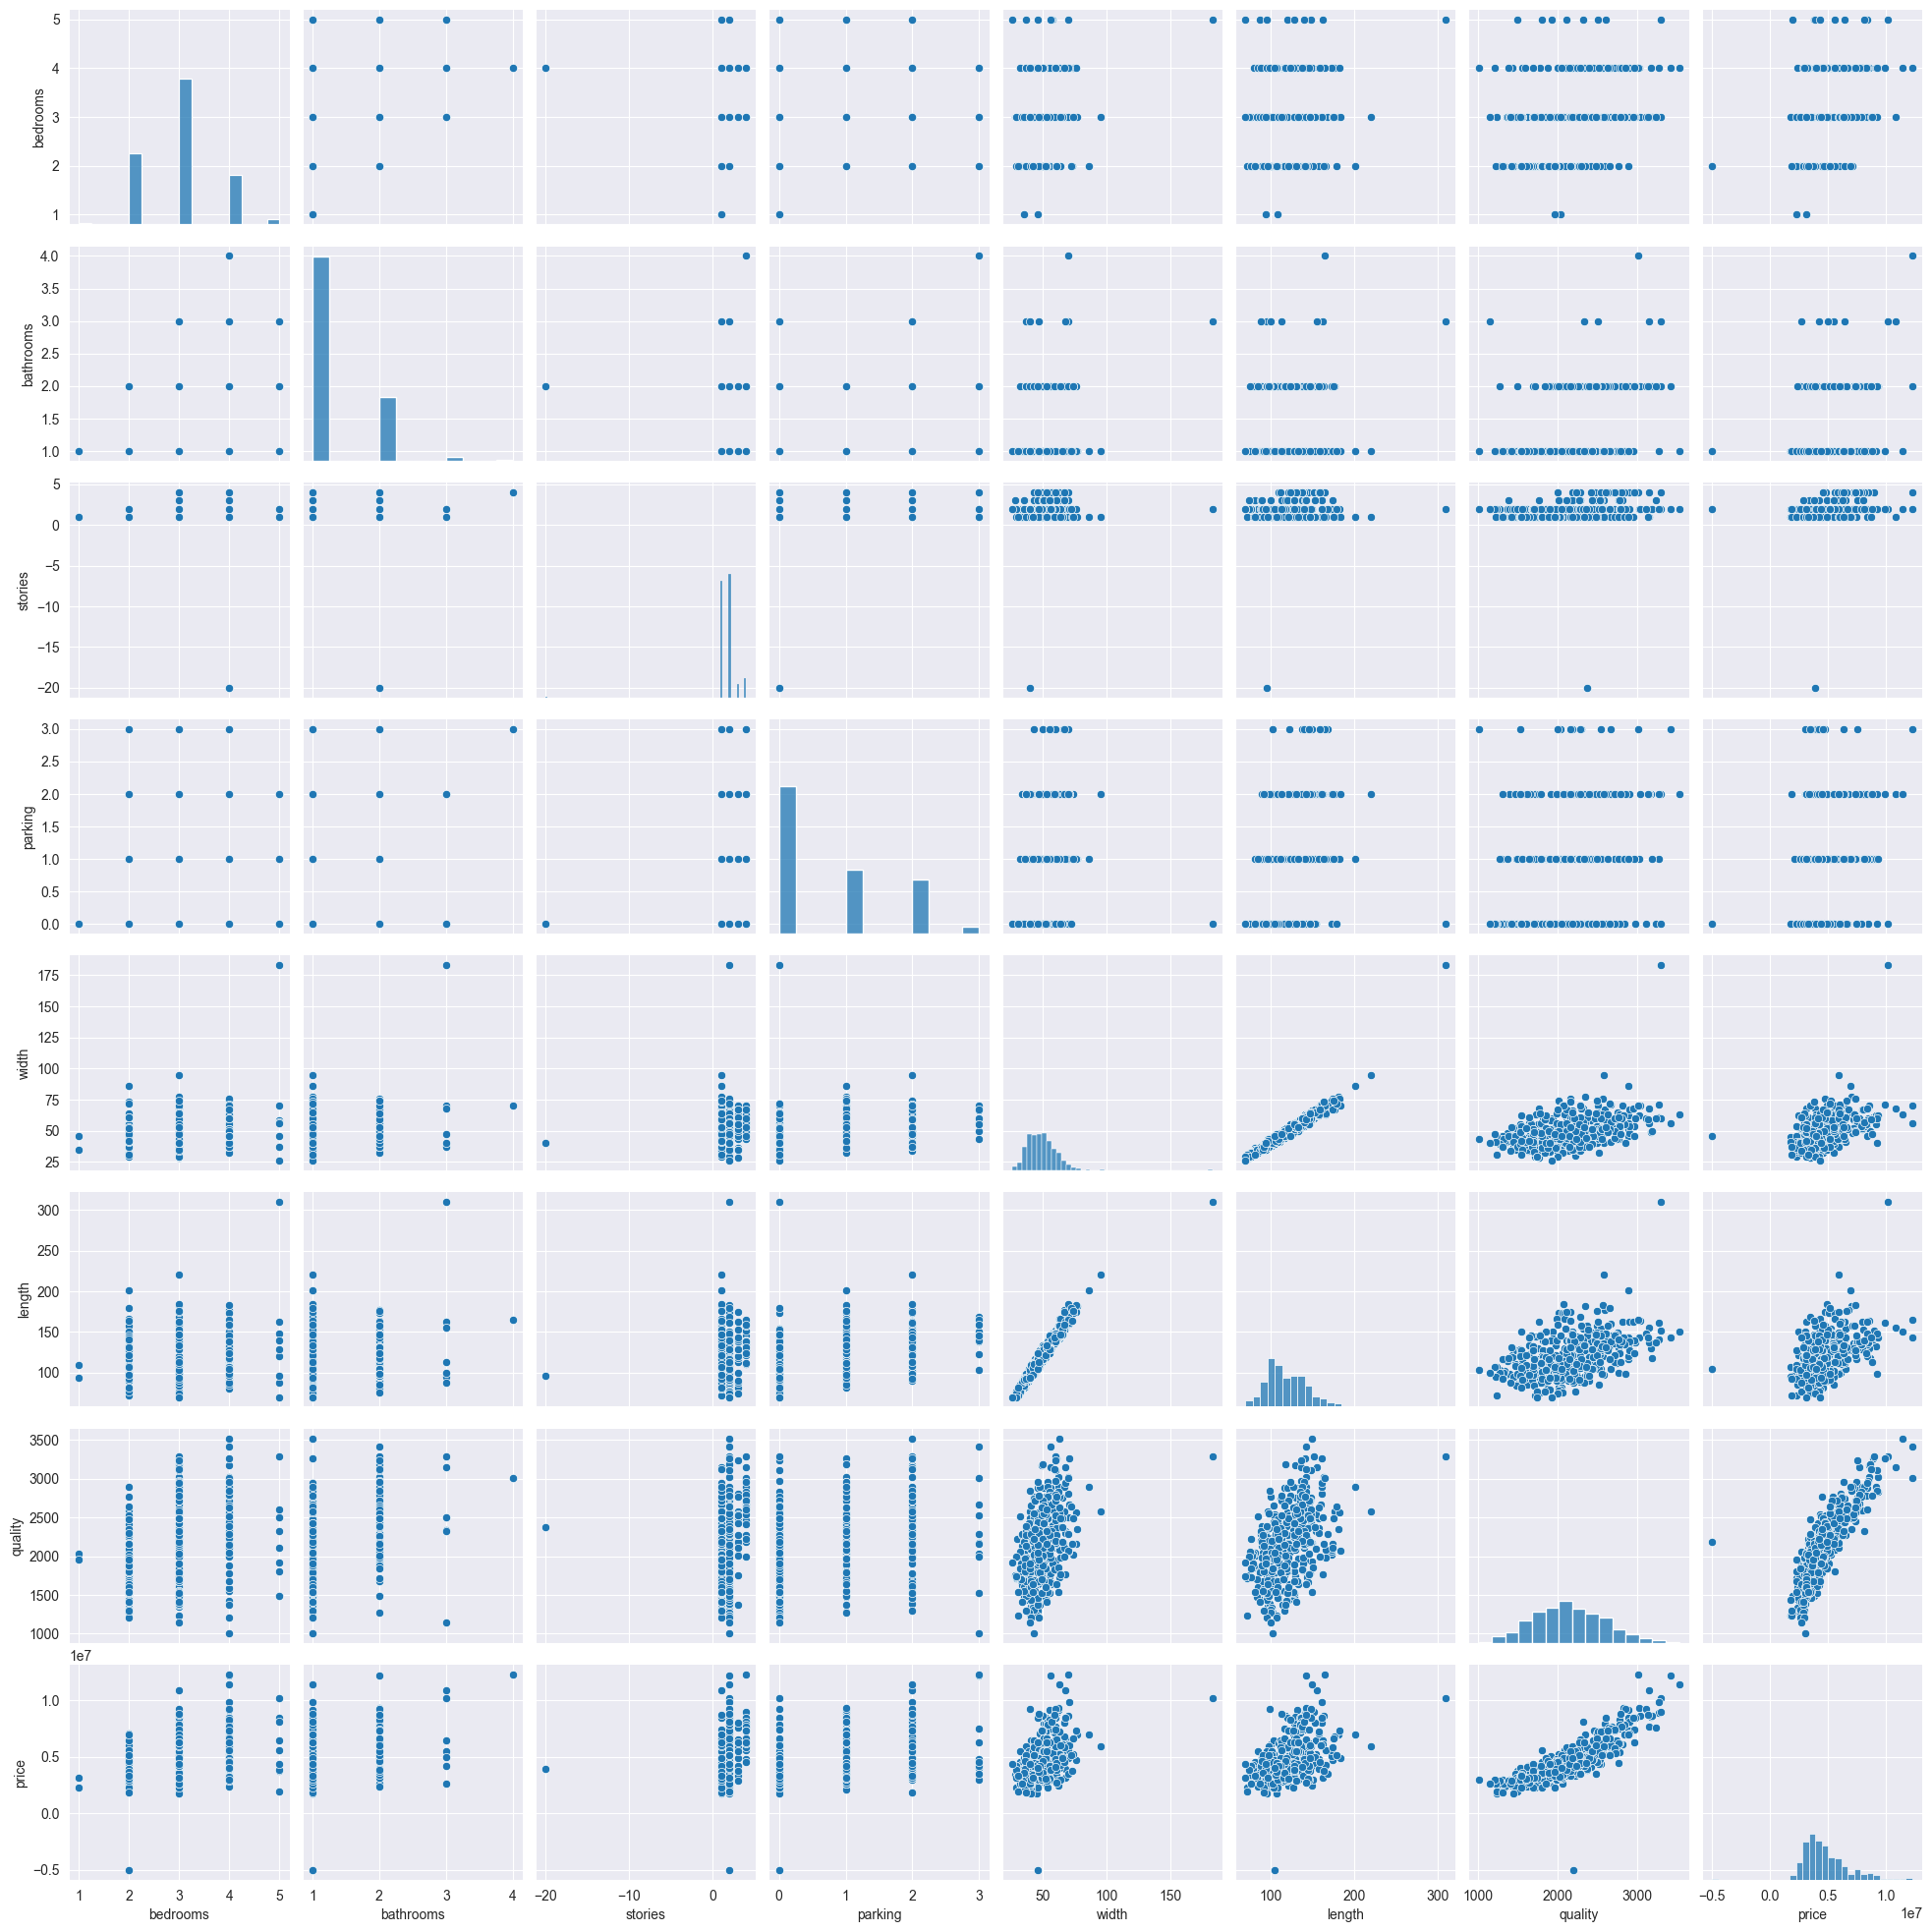

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train_dataset)
plt.show()

In the above visualization, we can see different interesting information:
1. Some independent variables show relationship with the target variable `price` (e.g., `quality`).
2. Some independent variables are correlated (e.g., `width` and `length`).
3. The `quality` independent variable has a symmetric and unimodal distribution.
4. The `price`, `width`, and `length` independent variables seem to have outliers causing a long tail in the distribution and not being symmetric (better seen in the first visualization).

### Outliers

We detect the outliers in the `quality` numerical feature using the IQR Tukey’s Fences rule. In the visualization, we saw that `quality` is a symmetric and unimodal (one single peek value) variable, so the requirements to apply Tukey's fences are met.

In [4]:
tukeys_features = ['quality']
# outliers_df holds True for outlier and False for inlier
tukey_outliers_df = utils.detect_outliers_iqr(train_dataset[tukeys_features], threshold=1.5) # 1.5 = mild outliers, 3.0 = extreme outliers
# We take the train dataset, filter the tukey's features apply the outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
tukey_outliers = train_dataset[tukeys_features][tukey_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print(f"Number of outliers in the training set using Tukey's Fences rule: {(n_outliers_tukey := tukey_outliers.shape[0])}.")
if n_outliers_tukey > 0:
    print("Values of the outliers in the training set:\n", tukey_outliers, end='\n\n')

Number of outliers in the training set using Tukey's Fences rule: 1.
Values of the outliers in the training set:
    quality
4   3521.0



The numeric variables `length` and `width` do not meet the requirements of the Tukey's Fences rule. However, they are unimodal and not highly asymmetric (asymmetric tail), so we can apply the modified Z-score method to detect outliers. These conditions are also met by the `bedrooms` and `stories` variables.

In [5]:
modified_z_features = ['length', 'width', 'bedrooms', 'stories']
# outliers_df holds True for outlier and False for inlier
modified_z_outliers_df = utils.detect_outliers_modified_z(train_dataset[modified_z_features], threshold=3.5)
# We take the train dataset, filter the modified z-score features apply the modified_z_outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
modified_z_outliers = train_dataset[modified_z_features][modified_z_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print(f"Number of outliers in the training set using Modified Z-score method: {(n_outliers_modified_z := modified_z_outliers.shape[0])}.")
if n_outliers_modified_z > 0:
    print("Values of the outliers in the training set using the Modified Z-score method:\n", modified_z_outliers, end='\n\n')

Number of outliers in the training set using Modified Z-score method: 4.
Values of the outliers in the training set using the Modified Z-score method:
      length  width  bedrooms  stories
7     310.0  183.0       NaN      NaN
344     NaN    NaN       NaN    -20.0
130   220.0   95.0       NaN      NaN
71    201.0   86.0       NaN      NaN



This is a summary of the outliers found:
- The `quality` variable has one outlier (Tukey's fences). It does not seem to be erroneous data, so we can scale their values to lessen the impact of their values ([`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) is less sensitive to outliers than `StandardScaler` because it uses the median and IQR instead of mean and standard deviation). If data is normal with no outliers, `StandardScaler` is a better choice.
- The `stories` variable holds one outlier (Modified Z-score). It is an error because there are no houses with 0 or fewer stories. We will set it to NaN and treat it as a missing value.
- The `width` and `length` of three samples are outliers (Modified Z-score). It does not seem to be erroneous data (they represent houses build on a big area), so we can scale their values to lessen the impact of their values (using `RobustScaler`).


In [6]:
# Set the negative values to NaN in the `stories`, `bathrooms` and `bedrooms` columns
non_negative_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
utils.modify_cells_lower_than(X_train, column_names=non_negative_vars, cell_value=np.nan, threshold=0)
utils.modify_cells_lower_than(X_test, column_names=non_negative_vars, cell_value=np.nan, threshold=0)
for non_negative_var in non_negative_vars:
    print(f"Number of values with '{non_negative_var}' < 0 in the training set: {X_train['stories'][X_train['stories'] < 0].count()}.",)
    print(f"Number of values with '{non_negative_var}' < 0 in the test set: {X_test['stories'][X_test['stories'] < 0].count()}.",)
# Remove the samples with negative values for the target variable (`price`) from both train and test datasets since we cannot deal with errors (imputation) in the target variable because it is precisely the value to predict.
y_train, X_train = utils.drop_rows_lower_than(y_train, X_train, threshold=0)
y_test, X_test = utils.drop_rows_lower_than(y_test, X_test, threshold=0)
print(f"Number of values with 'price' < 0 in the training set: {y_train[y_train < 0].count()}.")
print(f"Number of values with 'price' < 0 in the test set: {y_test[y_test < 0].count()}.")

Number of values with 'bedrooms' < 0 in the training set: 0.
Number of values with 'bedrooms' < 0 in the test set: 0.
Number of values with 'bathrooms' < 0 in the training set: 0.
Number of values with 'bathrooms' < 0 in the test set: 0.
Number of values with 'stories' < 0 in the training set: 0.
Number of values with 'stories' < 0 in the test set: 0.
Number of values with 'parking' < 0 in the training set: 0.
Number of values with 'parking' < 0 in the test set: 0.
Number of values with 'width' < 0 in the training set: 0.
Number of values with 'width' < 0 in the test set: 0.
Number of values with 'length' < 0 in the training set: 0.
Number of values with 'length' < 0 in the test set: 0.
Number of values with 'quality' < 0 in the training set: 0.
Number of values with 'quality' < 0 in the test set: 0.
Number of values with 'price' < 0 in the training set: 0.
Number of values with 'price' < 0 in the test set: 0.


### Missing values

First, we detect the missing values in the dataset. Then, we analyze the results and treat the missing values.

In [7]:
# We print the instances that have any missing values
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the train dataset:
      bedrooms  bathrooms  stories  parking  width  length  quality mainroad  \
56        4.0        2.0      2.0      1.0   62.0   143.0   3026.0      NaN   
57        4.0        2.0      4.0      2.0   60.0   138.0   2679.0      yes   
36        3.0        2.0      3.0      1.0   67.0   153.0      NaN      yes   
59        3.0        1.0      NaN      1.0    NaN   133.0   2498.0      yes   
344       4.0        2.0      NaN      0.0   40.0    96.0   2371.0      yes   
58        3.0        1.0      1.0      1.0    NaN     NaN   2841.0      yes   

    guestroom basement hotwaterheating airconditioning prefarea  \
56         no       no              no             yes      yes   
57         no       no              no              no       no   
36         no       no             yes              no      yes   
59         no       no             NaN             yes      NaN   
344        no       no              no              no       no   
58    

There are missing values in the dataset. We will treat them using the same criteria in train and test sets.

First, if there are 50% or more missing values in a sample, we will remove the whole sample.  **Important**: We should remove the corresponding rows in the target variable as well.

In [8]:
X_train, y_train = utils.drop_rows_multiple_missing_values(X_train, y_train, threshold=len(independent_vars)//2)
X_test, y_test = utils.drop_rows_multiple_missing_values(X_test, y_test, threshold=len(independent_vars)//2)

For the rest of the missing values, we saw in the visualization above that there is a strong correlation between the `width` and `length` variables. Therefore, we will impute the missing values in these two variables using a linear regression model (bidirectionally). If both variables are missing, we will leave their NaN values and treat them with univariate imputation methods later.

In [9]:
# impute the missing values in the 'width' variable using a simple linear regression model with 'length' as independent variable
X_train = utils.impute_one_column_from_another_vice_versa(X_train, ['width', 'length'])
X_test = utils.impute_one_column_from_another_vice_versa(X_test, ['width', 'length'])

In the visualization, we also saw a strong influence of the `quality` variable on the target variable `price`. Therefore, we will impute the missing values in the `quality` variable using a multi-variable  k-nearest neighbors (KNN) regression model with all the other independent variables as predictors. Although it requires more computational resources, it is expected to provide better results than using a univariate imputation.

We want to impute the missing values in the `quality` variable using all the columns, but we still have missing values in other columns. Thus, we will apply KNN to `quality` only after imputing the rest of missing values.

For the rest of the variables, we will impute the missing values using simple univariate imputation methods (other methods, including multivariate imputation methods, could be used as well):
- For numerical variables:
    - If they have outliers, we will use the median value because it is more robust to outliers.
    - If they do not have outliers, we could use mean.
- For the binary and nominal variables, we will use the most frequent value (mode).

Let's start by replacing the missing values for numerical variables in the dataset (excluding `quality`):

In [10]:
vars_with_outliers = ['width', 'length']
integer_vars_with_outliers = list(set(integer_independent_vars).intersection(vars_with_outliers) - {'quality'})
integer_vars_without_outliers = list(set(integer_independent_vars) - set(integer_vars_with_outliers) - {'quality'})
# impute the missing values in the integer variables with outliers using the median value
median_imputer = SimpleImputer(strategy='median')
X_train[integer_vars_with_outliers] = median_imputer.fit_transform(X_train[integer_vars_with_outliers])
X_test[integer_vars_with_outliers] = median_imputer.transform(X_test[integer_vars_with_outliers])
# impute the missing values in the integer variables without outliers using the mean value
mean_imputer = SimpleImputer(strategy='mean')
X_train[integer_vars_without_outliers] = mean_imputer.fit_transform(X_train[integer_vars_without_outliers])
X_test[integer_vars_without_outliers] = mean_imputer.transform(X_test[integer_vars_without_outliers])

Now, for the binary and nominal variables, we will use the most frequent value (mode).

In [11]:
binary_nominal_imputer = SimpleImputer(strategy='most_frequent')
binary_nominal_features = binary_independent_vars + nominal_independent_vars
X_train[binary_nominal_features] = binary_nominal_imputer.fit_transform(X_train[binary_nominal_features])
X_test[binary_nominal_features] = binary_nominal_imputer.transform(X_test[binary_nominal_features])

The only variable with missing values left should be `quality`, which we will impute later using KNN.

In [12]:
print("Missing values in the training and test sets after handling missing values.")
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the training and test sets after handling missing values.
Missing values in the train dataset:
     bedrooms  bathrooms  stories  parking  width  length  quality mainroad  \
36       3.0        2.0      3.0      1.0   67.0   153.0      NaN      yes   

   guestroom basement hotwaterheating airconditioning prefarea  \
36        no       no             yes              no      yes   

   furnishingstatus  
36        furnished  

Missing values in the test dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus]
Index: []



### Set the valid types for the variables

Nominal variables should be converted into numbers so that the model can understand them. First, we deal with binary variables, changing "yes" and "no" values to 1 and 0, respectively.

In [13]:
for feature_name in binary_independent_vars:
    X_train[feature_name] = X_train[feature_name].map({'yes': 1, 'no': 0})
    X_test[feature_name] = X_test[feature_name].map({'yes': 1, 'no': 0})

`furnishingstatus` cannot be converted into an ordinal integer value (label encoding) because it represents no order. Therefore, we use one-hot encoding to transform it into a format that the model can understand.

In [14]:
for feature_name in nominal_independent_vars:
    # print the different values in the feature
    X_train = pd.get_dummies(X_train, columns=[feature_name], dtype=int)  # sets it to 0 or 1 instead of True or False
    X_test = pd.get_dummies(X_test, columns=[feature_name], dtype=int)

### Multivariate imputation of `quality` using KNN

We can now impute `quality` using KNN, as indicated above.

In [15]:
X_train = utils.impute_one_column_knn(X_train, 'quality')
X_test = utils.impute_one_column_knn(X_test, 'quality')

There should be no missing values in the dataset.

In [16]:
print("Missing values in the training and test sets after handling missing values.")
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the training and test sets after handling missing values.
Missing values in the train dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus_furnished, furnishingstatus_semi-furnished, furnishingstatus_unfurnished]
Index: []

Missing values in the test dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus_furnished, furnishingstatus_semi-furnished, furnishingstatus_unfurnished]
Index: []



We have finished the data preparation. We finally visualize the influence of the features on the target variable and store the curated dataset in a single csv file.

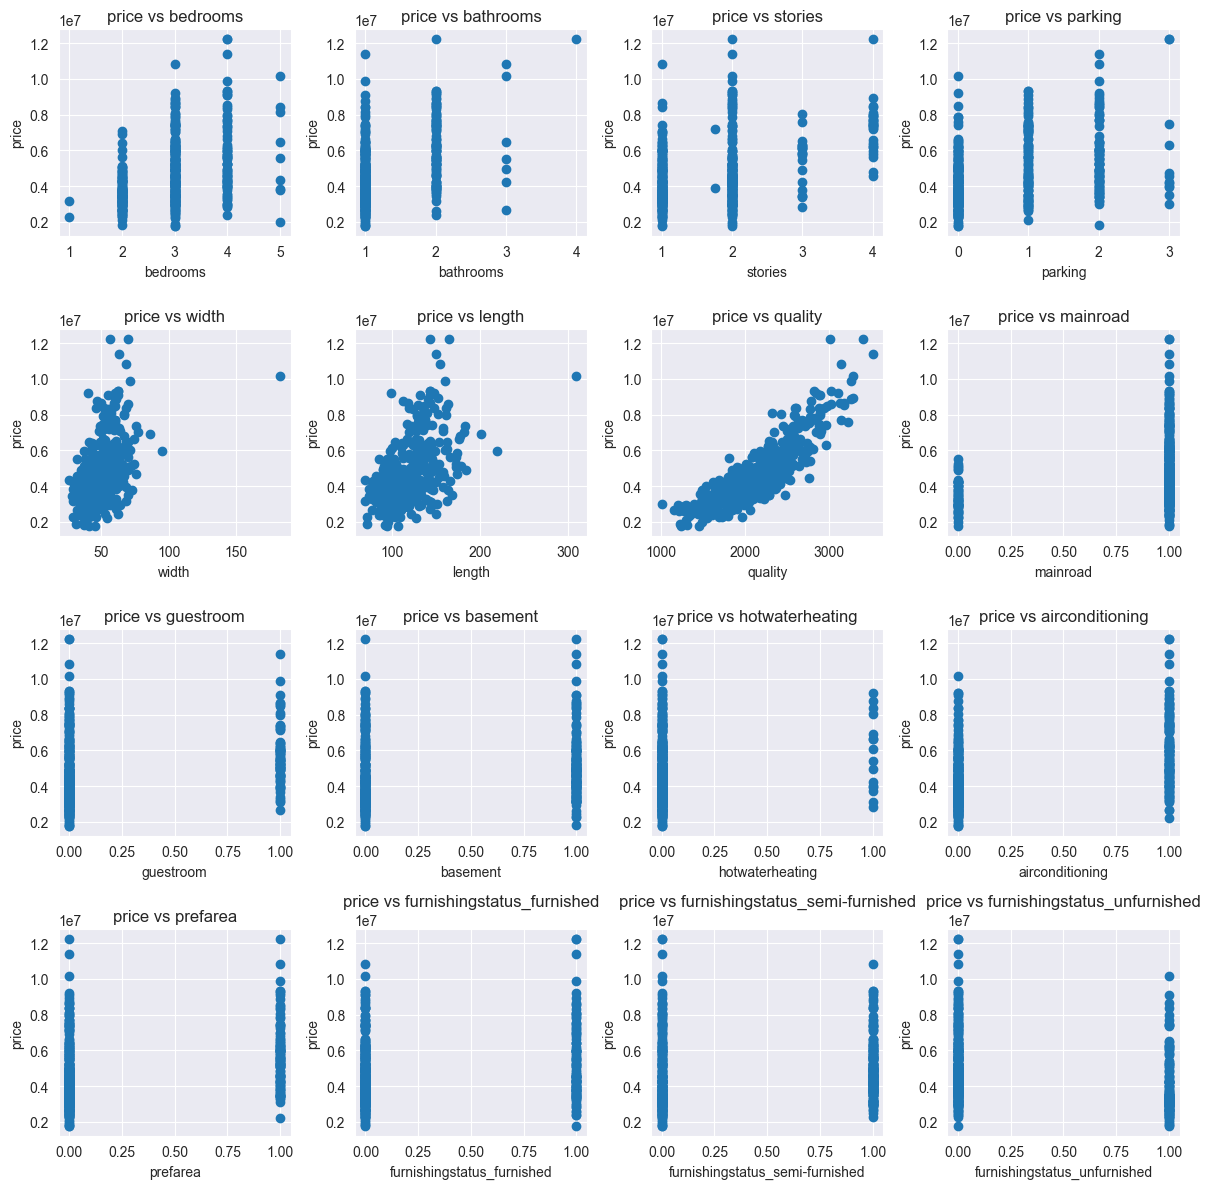

In [17]:
# Visualize the influence of the features on the target variable
utils.visualize_influence(X_train, y_train)
# Store the curated X_train, X_test, y_train and y_text merged in a single csv file
utils.store_dataset(X_train, y_train, X_test, y_test, 'data/housing_curated.csv')

## Model creation, training, and evaluation

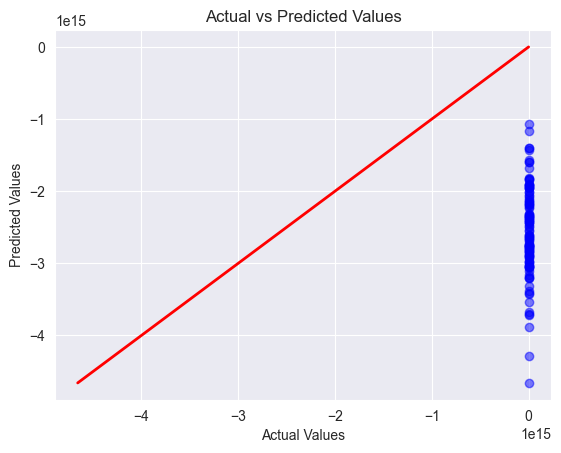

Mean Squared Error (MSE): 6904313148084585641183790759936.0000
Root Mean Squared Error (RMSE): 2627605972760106.5000
Mean Absolute Error (MAE): 2552862480318295.0000
R-squared determination coefficient: -1478572902283347968.0000



In [18]:
metrics= utils.create_SDG_regression_model_and_evaluate(X_train, y_train, X_test, y_test, random_state)
utils.show_regression_performance(*metrics)

## ✨ Activity 1 ✨

The previous model does not perform well. After reading all the previous code, there is something we should have done, and we have not done. Can you identify what it is? Do it and check if the model has increased its performance. 

In [19]:
# Write your code here.

 

## ✨ Activity 2 ✨

Does it occur to you to perform any *feature engineering* to improve the model? Do one step after another and check if the model has increased its performance.

In [20]:
# Write your code here.

 